Задача лабораторной работы 10

In [ ]:
# 1. Текстурные характеристики:
# 1.1. Реализуйте подсчет гистограммы 
# 1.2. Реализуйте рассчет текстурных характеристик Laws 
# 1.3. Реализуйте расчет текстурных характеристик на основе матрицы взаимной встречаемости GLCM

# 2. Для каждого случая: выполните тренировку классификатора (knn, svm, trees)

# 3. Решите задачу сегментации данных на основе классификации изображений каждым методом.

# 4.1. Выполните ручную разметку изображений на регионы.
# 4.2. Сравните результат полученной классификации и размеченной.

Импорт библиотек и написание функции гистограммы (рандомное изображение из датасета)

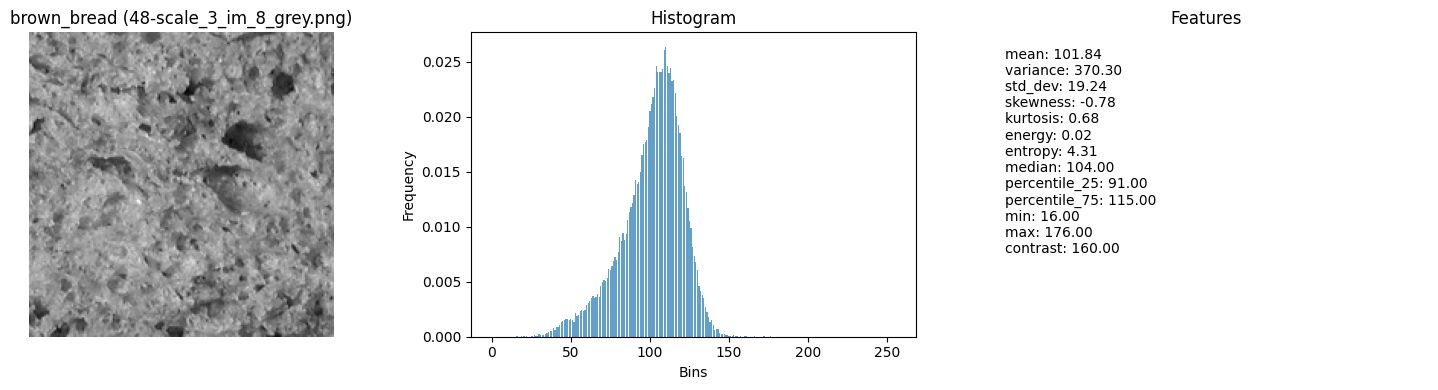

In [ ]:
import cv2 as cv
import numpy as np
import os
import matplotlib.pyplot as plt
import random
from scipy.stats import entropy, skew, kurtosis

def compute_histogram(image, bins):
    hist = cv.calcHist([image], [0], None, [bins], [0, 256])
    hist = hist.flatten()
    
    bin_width = 256 / bins
    bin_centers = np.array([i * bin_width + bin_width / 2 for i in range(bins)])
    hist_normalized = hist / np.sum(hist)
    
    weighted_data = np.repeat(bin_centers, hist.astype(int))
    
    features = {
        'mean': np.average(bin_centers, weights=hist),
        'variance': np.var(weighted_data) if len(weighted_data) > 0 else 0,
        'std_dev': np.std(weighted_data) if len(weighted_data) > 0 else 0,
        'skewness': skew(weighted_data) if len(weighted_data) > 0 else 0,
        'kurtosis': kurtosis(weighted_data) if len(weighted_data) > 0 else 0,
        'energy': np.sum(hist_normalized**2),
        'entropy': entropy(hist_normalized),
        'median': np.median(image),
        'percentile_25': np.percentile(image, 25),
        'percentile_75': np.percentile(image, 75),
        'min': np.min(image),
        'max': np.max(image),
        'contrast': np.max(image) - np.min(image)
    }
    
    return features, hist_normalized

image_folder = "./kth_tips_grey_200x200/KTH_TIPS"

# в данном случая я беру и выбираю рандомную категорию для структуры и потом выбираю рандомную картинку для
# подстчёта гистограммы и некторых характеристик а так же было принято решение исходя из выпавшей категории
# я выбираю изображение для тестирования в последующей части работы 

texture_names = os.listdir(image_folder)
texture_name = random.choice(texture_names) 
texture_path = os.path.join(image_folder, texture_name)

image_files = [f for f in os.listdir(texture_path)]

image_file = random.choice(image_files)
image_path = os.path.join(texture_path, image_file)
image = cv.imread(image_path, cv.IMREAD_GRAYSCALE)

bins_count = 256
features, hist = compute_histogram(image, bins=bins_count)

fig, (ax_img, ax_hist, ax_stats) = plt.subplots(1, 3, figsize=(15, 4))

ax_img.imshow(image, cmap='gray')
ax_img.set_title(f'{texture_name} ({image_file})')
ax_img.axis('off')

ax_hist.bar(range(bins_count), hist, alpha=0.7)
ax_hist.set_title('Histogram')
ax_hist.set_xlabel('Bins')
ax_hist.set_ylabel('Frequency')

stats_text = '\n'.join([f'{k}: {v:.2f}' for k, v in features.items()])
ax_stats.text(0.05, 0.95, stats_text, transform=ax_stats.transAxes, verticalalignment='top')
ax_stats.set_title('Features')
ax_stats.axis('off')

plt.tight_layout()
plt.show()

Характеристики Laws

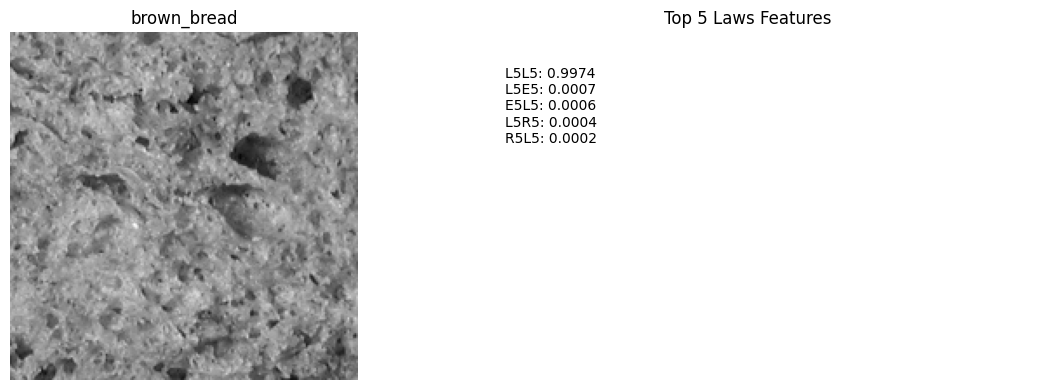

In [ ]:
def laws_texture(image):
    kernels = [
        ([1,4,6,4,1], 'L5'),
        ([-1,-2,0,2,1], 'E5'), 
        ([-1,0,2,0,-1], 'S5'), 
        ([-1,2,0,-2,1], 'W5'), 
        ([1,-4,6,-4,1], 'R5') 
    ]
    
    features_dict = {}

    for k1, name1 in kernels:
        for k2, name2 in kernels:
            kernel = np.outer(k1, k2)
            filtered = cv.filter2D(image.astype(np.float32), -1, kernel)
            features_dict[f"{name1}{name2}"] = np.mean(filtered ** 2)

    total = sum(features_dict.values())
    if total > 0:
        for key in features_dict:
            features_dict[key] /= total
    
    return features_dict

fig, (ax_img, ax_stats) = plt.subplots(1, 2, figsize=(12, 4))

ax_img.imshow(image, cmap='gray')
ax_img.set_title(texture_name)
ax_img.axis('off')

top_5 = sorted(features_dict.items(), key=lambda x: x[1], reverse=True)[:5]
stats_text = '\n'.join([f'{k}: {v:.4f}' for k, v in top_5])

ax_stats.text(0.1, 0.9, stats_text, transform=ax_stats.transAxes, verticalalignment='top')
ax_stats.set_title('Top 5 Laws Features')
ax_stats.axis('off')

plt.tight_layout()
plt.show()

Характеристики Glcm

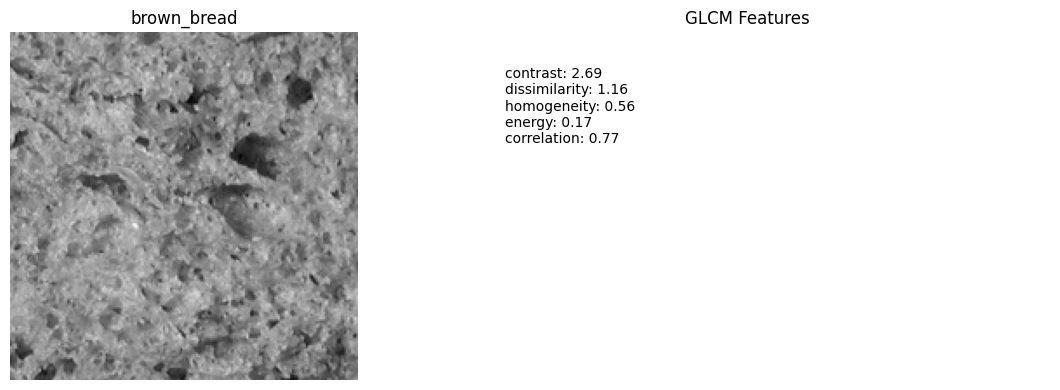

In [ ]:
from skimage.feature import graycomatrix, graycoprops

def compute_glcm_features(image):
    distances = [1]
    angles = [0, np.pi / 4, np.pi / 2, 3 * np.pi / 4]

    image_quantized = (image // 8).astype(np.uint8)
    glcm = graycomatrix(
        image_quantized, 
        distances=distances, 
        angles=angles, 
        levels=32, 
        symmetric=True, 
        normed=True
    )
    
    properties = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']
    features = {}
    
    for prop in properties:
        feature_val = np.mean(graycoprops(glcm, prop))
        features[prop] = feature_val
    
    return features

features = compute_glcm_features(image)

fig, (ax_img, ax_stats) = plt.subplots(1, 2, figsize=(12, 4))

ax_img.imshow(image, cmap='gray')
ax_img.set_title(texture_name)
ax_img.axis('off')

stats_text = '\n'.join([f'{k}: {v:.2f}' for k, v in features.items()])

ax_stats.text(0.1, 0.9, stats_text, transform=ax_stats.transAxes, verticalalignment='top')
ax_stats.set_title('GLCM Features')
ax_stats.axis('off')

plt.tight_layout()
plt.show()

Подготовка наших данных и обучение моделей

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score
import warnings

def prepare_dataset(image_folder, feature_type, num_images=50):
    features, labels = [], []
    
    for texture_name in os.listdir(image_folder):
        texture_path = os.path.join(image_folder, texture_name)
        if not os.path.isdir(texture_path):
            continue
        
        for image_file in os.listdir(texture_path)[:num_images]:
            image_path = os.path.join(texture_path, image_file)
            image = cv.imread(image_path, cv.IMREAD_GRAYSCALE)
            
            if image is not None:
                image = cv.resize(image, (128, 128))
                
                if feature_type == 'Histogram':
                    features_dict, _ = compute_histogram(image, 256)
                elif feature_type == 'Laws':
                    features_dict = laws_texture(image)
                else:  # GLCM
                    features_dict = compute_glcm_features(image)
                
                features.append(list(features_dict.values()))
                labels.append(texture_name)
    
    return np.array(features), labels

def train_models(X, y):
    y_encoded = LabelEncoder().fit_transform(y)
    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.25, random_state=42, stratify=y_encoded)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    classifiers = {
        'KNN': KNeighborsClassifier(n_neighbors=3, n_jobs=-1),
        'SVM': SVC(kernel='rbf', random_state=42),
        'DecisionTree': DecisionTreeClassifier(random_state=42, max_depth=10)
    }
    
    models = {name: clf.fit(X_train_scaled, y_train) for name, clf in classifiers.items()}

    return models, X_test_scaled, y_test, scaler

trained_models_dict = {}

feature_types = ['Histogram', 'Laws', 'GLCM']
for feature_type in feature_types:
    print(f"Training {feature_type} models...")
    
    X, labels = prepare_dataset(image_folder, feature_type, 50)
    models, X_test, y_test, scaler = train_models(X, labels)
    
    trained_models_dict[feature_type] = {
        'models': models, 'scaler': scaler
    }
    
    print(f"  Data: {X.shape}")
    for name, model in models.items():
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
            f1 = report['macro avg']['f1-score']
        
        print(f"  {name}: Acc={accuracy:.3f}, F1={f1:.3f}")
    print()

Training Histogram models...
  Data: (500, 13)
  KNN: Acc=0.872, F1=0.875
  SVM: Acc=0.760, F1=0.760
  DecisionTree: Acc=0.744, F1=0.743

Training Laws models...
  Data: (500, 25)
  KNN: Acc=0.824, F1=0.826
  SVM: Acc=0.536, F1=0.520
  DecisionTree: Acc=0.688, F1=0.687

Training GLCM models...
  Data: (500, 5)
  KNN: Acc=0.704, F1=0.704
  SVM: Acc=0.544, F1=0.546
  DecisionTree: Acc=0.624, F1=0.630



 Функции для сегментации

In [ ]:
def texture_segmentation(image, trained_models_dict, feature_type, model_name, window_size=32, step=None, n_classes=4):
    original_image = cv.imread(image, cv.IMREAD_GRAYSCALE)
    
    if step is None:
        step = window_size

    models = trained_models_dict[feature_type]['models']
    scaler = trained_models_dict[feature_type]['scaler']
    model = models[model_name]
    
    h, w = original_image.shape
    temp_seg_map = np.zeros((h, w), dtype=np.uint8)
    all_predictions = []
    
    feature_extractors = {
        'Histogram': lambda img: list(compute_histogram(img, 32)[0].values()),
        'Laws': lambda img: list(laws_texture(img).values()),
        'GLCM': lambda img: list(compute_glcm_features(img).values())
    }

    for y in range(0, h - window_size + 1, step):
        for x in range(0, w - window_size + 1, step):
            window = original_image[y:y+window_size, x:x+window_size]
            
            features = feature_extractors[feature_type](window)
            features_scaled = scaler.transform([features])
            prediction = model.predict(features_scaled)[0]
            
            temp_seg_map[y:y+window_size, x:x+window_size] = prediction
            all_predictions.append(prediction)

    unique, counts = np.unique(all_predictions, return_counts=True)
    top_classes = unique[np.argsort(counts)[-n_classes:]]
    
    segmentation_map = np.zeros_like(temp_seg_map)
    
    for new_class, old_class in enumerate(top_classes):
        segmentation_map[temp_seg_map == old_class] = new_class

    mask_not_top = ~np.isin(temp_seg_map, top_classes)
    if np.any(mask_not_top):
        segmentation_map[mask_not_top] = 1 
    
    return segmentation_map, original_image

def show_segment(image, trained_models_dict, **kwargs):
    seg_map, original = texture_segmentation(image, trained_models_dict, **kwargs)
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
    
    ax1.imshow(original, cmap='gray')
    ax1.set_title('Original')
    ax1.axis('off')
    
    ax2.imshow(seg_map, cmap='tab10')
    ax2.set_title('Segmentation')
    ax2.axis('off')
    
    ax3.imshow(seg_map, cmap='tab10', alpha=0.8)
    ax3.imshow(original, cmap='gray', alpha=0.3)
    ax3.set_title('Overlay')
    ax3.axis('off')
    
    plt.tight_layout()
    plt.show()

Тестирование сегментации (на своём изображении)

Laws - SVM segmentation:


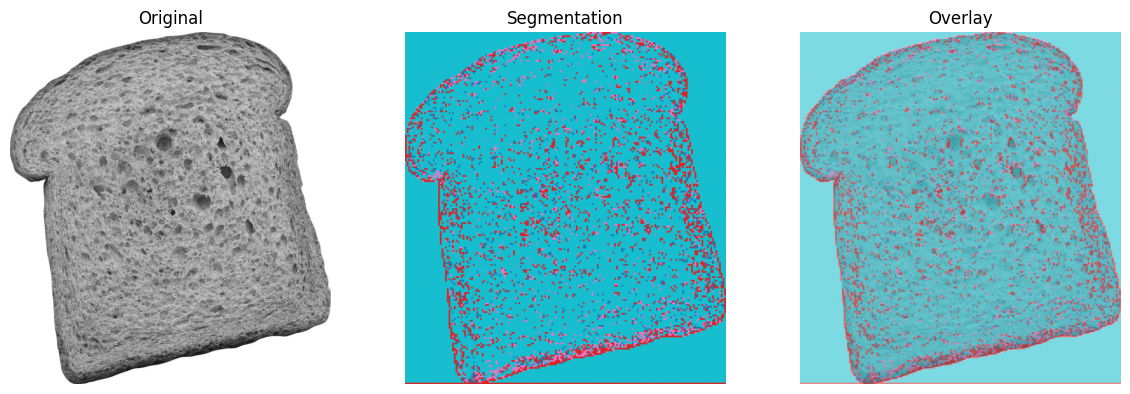

GLCM - DecisionTree segmentation:


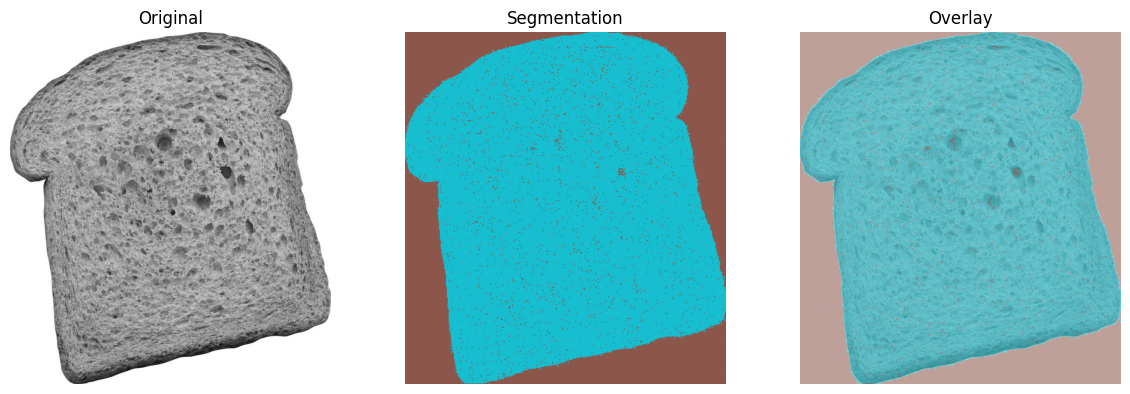

In [ ]:
image_path = "C:\\Users\\wwwti\\OneDrive\\Рабочий стол\\Image processing\\ip\\ip10\\e7acd183d5c331bb856a6e89dd8069b2.jpg"

print("Laws - SVM segmentation:")
show_segment(image_path, trained_models_dict, window_size=4, feature_type='Laws', model_name='SVM')

print("GLCM - DecisionTree segmentation:")
show_segment(image_path, trained_models_dict, window_size=2, feature_type='GLCM', model_name='DecisionTree')

Выполнение ручной разметки

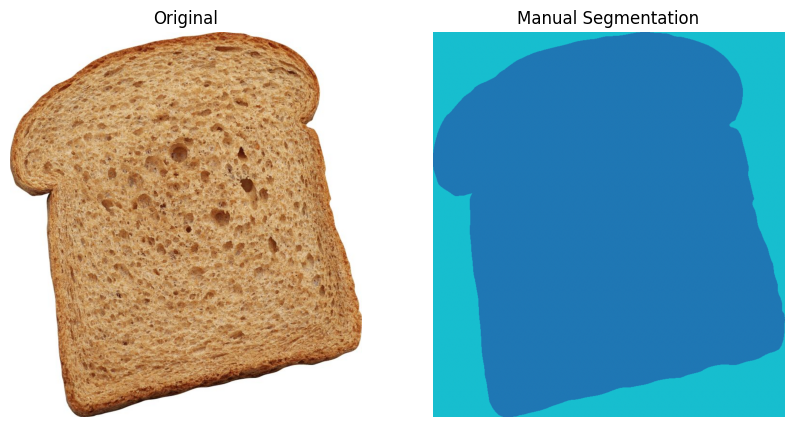

In [ ]:
def manual_segment(image):
    image_gray = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
    _, mask = cv.threshold(image_gray, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)
    
    contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    final_mask = np.zeros_like(mask)

    if contours:
        largest_contour = max(contours, key=cv.contourArea)
        cv.drawContours(final_mask, [largest_contour], 0, 1, -1)
    
    return final_mask

def remap_classes(mask, n_classes):
    unique, counts = np.unique(mask, return_counts=True)
    top_classes = unique[np.argsort(-counts)[:n_classes]]

    result = np.zeros_like(mask)
    for new_id, old_id in enumerate(top_classes):
        result[mask == old_id] = new_id

    return result

image_path = "C:\\Users\\wwwti\\OneDrive\\Рабочий стол\\Image processing\\ip\\ip10\\e7acd183d5c331bb856a6e89dd8069b2.jpg"
image = cv.imread(image_path)
image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)

manual_mask = manual_segment(image_rgb)
manual_mask = remap_classes(manual_mask, 4)

fig, (ax_orig, ax_segment) = plt.subplots(1, 2, figsize=(10, 5))

ax_orig.imshow(image_rgb)
ax_orig.set_title('Original')
ax_orig.axis('off')

ax_segment.imshow(manual_mask, cmap='tab10')
ax_segment.set_title('Manual Segmentation')
ax_segment.axis('off')

plt.show()

 Финальное сравнение результатов

GLCM - DecisionTree

Accuracy: 97.6%
IoU per class:
  Class 0: 0.968
  Class 1: 0.917


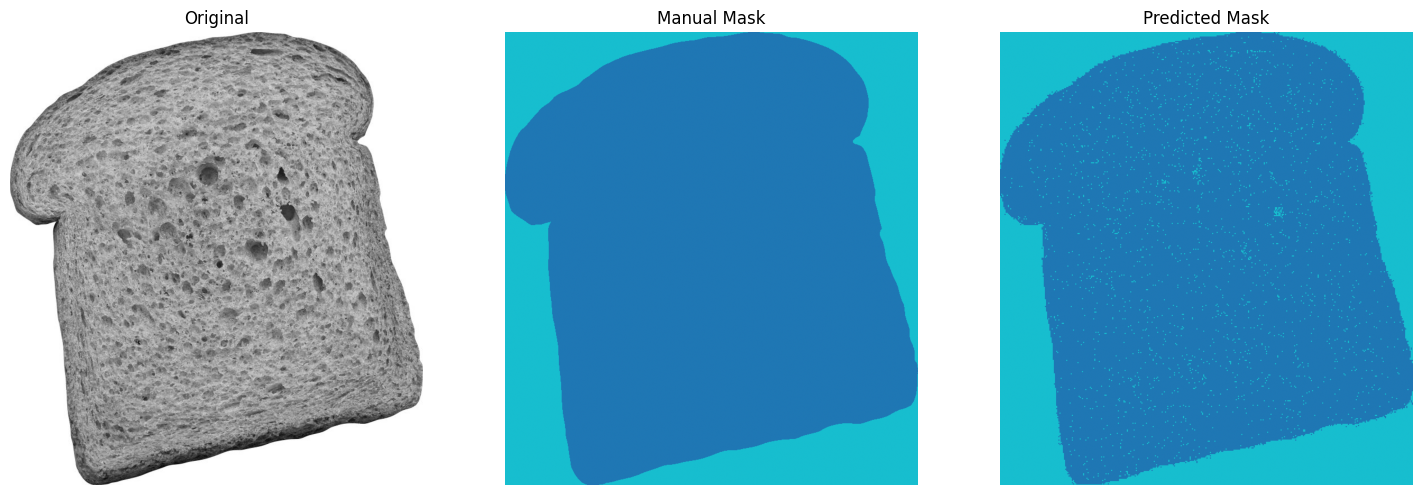

In [ ]:
from sklearn.metrics import accuracy_score, jaccard_score

def find_best_mapping(true_mask, pred_mask):
    true_flat = true_mask.flatten()
    pred_flat = pred_mask.flatten()
    
    true_classes = np.unique(true_flat)
    pred_classes = np.unique(pred_flat)
    
    mapping = {}
    for pred_class in pred_classes:
        best_true_class = None
        best_overlap = -1
        
        for true_class in true_classes:
            overlap = np.sum((true_flat == true_class) & (pred_flat == pred_class))
            if overlap > best_overlap:
                best_overlap = overlap
                best_true_class = true_class
        
        mapping[pred_class] = best_true_class
    
    return mapping

def compare_segmentation(manual_mask, predicted_mask, original_img):
    if manual_mask.shape != predicted_mask.shape:
        predicted_mask = cv.resize(predicted_mask, (manual_mask.shape[1], manual_mask.shape[0]))
    
    mapping = find_best_mapping(manual_mask, predicted_mask)
    pred_mapped = np.zeros_like(predicted_mask)
    
    for pred_class, true_class in mapping.items():
        pred_mapped[predicted_mask == pred_class] = true_class
    
    accuracy = accuracy_score(manual_mask.flatten(), pred_mapped.flatten())
    iou_scores = jaccard_score(manual_mask.flatten(), pred_mapped.flatten(), 
                              average=None, labels=np.unique(manual_mask))

    print(f"Accuracy: {accuracy:.1%}")
    
    print("IoU per class:")
    for i, class_id in enumerate(np.unique(manual_mask)):
        print(f"  Class {class_id}: {iou_scores[i]:.3f}")

    fig, (ax_orig, ax_manual, ax_pred) = plt.subplots(1, 3, figsize=(15, 5))
    
    ax_orig.imshow(original_img, cmap='gray')
    ax_orig.set_title('Original')
    ax_orig.axis('off')
    
    ax_manual.imshow(manual_mask, cmap='tab10')
    ax_manual.set_title('Manual Mask')
    ax_manual.axis('off')
    
    ax_pred.imshow(pred_mapped, cmap='tab10')
    ax_pred.set_title('Predicted Mask')
    ax_pred.axis('off')
    
    plt.tight_layout()
    plt.show()

# здесь происходит сравнение для GLCM с DecisionTree
feature_type = 'GLCM'
model_name = 'DecisionTree'
print(f"{feature_type} - {model_name}\n")

predicted_mask, _ = texture_segmentation(
    image_path, 
    trained_models_dict,
    window_size=2, 
    feature_type=feature_type, 
    model_name=model_name
)

image = cv.imread(image_path, cv.IMREAD_GRAYSCALE)
compare_segmentation(manual_mask, predicted_mask, image)